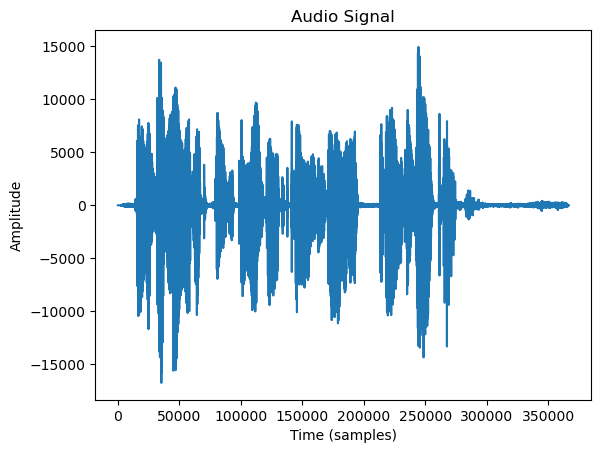

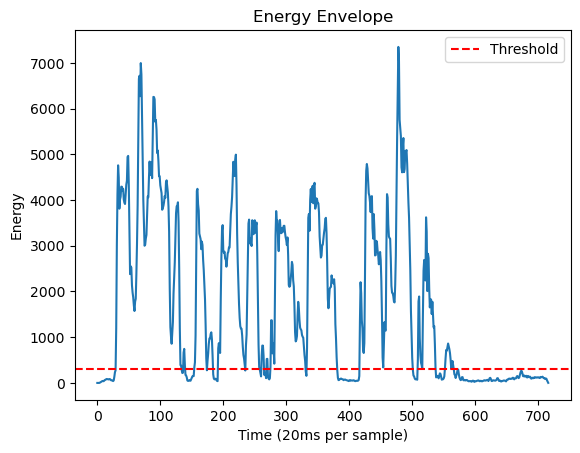

Energy below threshold: 72 / 717 samples
[(0.0, 117.33333333333333), (256.0, 277.3333333333333), (1536.0, 1557.3333333333333), (1578.6666666666667, 1589.3333333333333), (2026.6666666666667, 2048.0), (4245.333333333333, 4266.666666666667), (4288.0, 4298.666666666667), (4320.0, 4330.666666666667), (4352.0, 4426.666666666667), (6272.0, 6453.333333333333), (6464.0, 6549.333333333333), (6570.666666666667, 6581.333333333333), (6624.0, 6634.666666666667), (6677.333333333333, 6698.666666666667), (6730.666666666667, 6752.0), (6805.333333333333, 6880.0), (6901.333333333334, 6933.333333333334)]


<_io.BufferedRandom name='output_with_pauses.mp3'>

In [6]:
import numpy as np
import librosa
from pydub import AudioSegment

import matplotlib.pyplot as plt

# Function to detect potential pause locations in an audio segment
def detect_pause_locations(audio_segment, threshold=300, min_duration=1.0):
    # Convert audio segment to numpy array
    samples = np.array(audio_segment.get_array_of_samples())
    
    # Print the audio signal for visualization
    plt.plot(samples)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.title('Audio Signal')
    plt.show()

    # Calculate the energy envelope using the short-time Fourier transform (STFT)
    energy = librosa.feature.rms(y=samples, frame_length=1024, hop_length=512)[0]
    
    # Print the energy envelope for visualization
    plt.plot(energy)
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.xlabel('Time (20ms per sample)')
    plt.ylabel('Energy')
    plt.title('Energy Envelope')
    plt.legend()
    plt.show()

    # Find the threshold value of the pause
    energy_threshold = np.percentile(energy, 10)

    # Count the number of samples that are below the threshold
    energy_below_threshold = np.sum(energy < energy_threshold)
    print(f"Energy below threshold: {energy_below_threshold} / {len(energy)} samples")

    # Find intervals where energy is below the threshold and longer than the minimum duration
    sample_rate = audio_segment.frame_rate
    pause_locations = []
    pause_start = None
    for i, e in enumerate(energy):
        if e < energy_threshold:
            if pause_start is None:
                pause_start = i * 512 / sample_rate * 1000  # Convert index to time in seconds
        elif pause_start is not None:
            pause_end = i * 512 / sample_rate * 1000
            if pause_end - pause_start >= min_duration:
                pause_locations.append((pause_start, pause_end))
            pause_start = None
    
    return pause_locations

# Function to add pauses to an audio segment
def add_pauses_to_segment(audio_segment, pause_duration=1000):
    pause_segments = []
    pause_locations = detect_pause_locations(audio_segment)

    print(pause_locations)
    
    # Split the audio segment at pause locations and insert pauses
    start_time = 0
    for pause_start, pause_end in pause_locations:
        # Add audio before the pause
        pause_segments.append(audio_segment[start_time:int(pause_start)])
        # Add a pause segment
        pause_segments.append(AudioSegment.silent(duration=pause_duration))
        start_time = int(pause_end)
        
    # Concatenate audio segments with pauses
    paused_audio = AudioSegment.empty()
    for segment in pause_segments:
        paused_audio += segment
    
    return paused_audio

# Example usage:
input_file = "input.mp3"
output_file = "output_with_pauses.mp3"

audio = AudioSegment.from_file(input_file)
paused_audio = add_pauses_to_segment(audio)

# Export the modified audio with pauses
paused_audio.export(output_file, format="mp3")
